In [1]:
import os
import glob
import random
import time
import json
import warnings 
import torch.nn.functional as F
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2


# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

/opt/conda/envs/open-mmlab/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os.path as osp
import mmcv
from mmcv import Config
import pandas as pd
from pandas import DataFrame

import argparse
import os.path as osp
import shutil
import time
import warnings

import mmcv
import torch
from mmcv.cnn.utils import revert_sync_batchnorm
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)
from mmcv.utils import DictAction

from mmseg import digit_version
from mmseg.apis import single_gpu_test
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.utils import setup_multi_processes

In [3]:
os.chdir("../")

In [4]:
## 원하는 config, checkpoint 경로
config_path = '/opt/ml/main/level2-semantic-segmentation-level2-cv-14/mmsegmentation/configs/knet_swinL/knet_swinL.py'
checkpoint_path = '/opt/ml/main/level2-semantic-segmentation-level2-cv-14/work_dirs/knet_swinL/best_mIoU_epoch_41.pth'

In [5]:
# 시각화 palette -> 수정 가능
palette = [
    [0, 0, 0],
    [192, 0, 128],
    [0, 128, 192],
    [0, 128, 64],
    [128, 0, 0], 
    [64, 0, 128], 
    [64, 0, 192],
    [192, 128, 64], 
    [192, 192, 128], 
    [64, 64, 128], 
    [128, 0, 192]
    ]
    
classes = ['Background', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic','Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
category_and_rgb = [[classes, (r,g,b)] for classes, (r, g, b) in zip(classes, palette)]

In [6]:
# DataLoader 생성
cfg = Config.fromfile(config_path)
seed = 42
cfg.data.test.test_mode = True

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

# val loader
val_dataset = build_dataset(cfg.data.val)
val_data_path = cfg.data.val.img_dir
val_ann_path = cfg.data.val.ann_dir
val_loader = build_dataloader(
        val_dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

# train loader
cfg.data.val.img_dir = train_data_path = cfg.data.train.img_dir
cfg.data.val.ann_dir = train_ann_path = cfg.data.train.ann_dir
train_dataset = build_dataset(cfg.data.val)
train_loader = build_dataloader(
        train_dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

# test loader
test_dataset = build_dataset(cfg.data.test)
test_data_path = cfg.data.test.img_dir
test_loader = build_dataloader(
        test_dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

2022-04-29 13:23:08,528 - mmseg - INFO - Loaded 655 images
2022-04-29 13:23:08,581 - mmseg - INFO - Loaded 2617 images
2022-04-29 13:23:08,593 - mmseg - INFO - Loaded 624 images


In [7]:
model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = train_dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

load checkpoint from local path: /opt/ml/main/level2-semantic-segmentation-level2-cv-14/work_dirs/knet_swinL/best_mIoU_epoch_41.pth


In [8]:
# output 계산
train_output = single_gpu_test(model, train_loader)
val_output = single_gpu_test(model, val_loader)
test_output = single_gpu_test(model, test_loader)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 624/624, 5.3 task/s, elapsed: 118s, ETA:     0s[                                                  ] 0/655, elapsed: 0s, ETA:[                                                  ] 0/624, elapsed: 0s, ETA:

In [9]:
train_data_list =sorted(glob.glob(os.path.join(cfg.data.train.data_root, train_data_path, '*')))
train_ann_list =sorted(glob.glob(os.path.join(cfg.data.train.data_root, train_ann_path, '*')))
val_data_list =sorted(glob.glob(os.path.join(cfg.data.val.data_root, val_data_path, '*')))
val_ann_list =sorted(glob.glob(os.path.join(cfg.data.val.data_root, val_ann_path, '*')))
test_data_list =sorted(glob.glob(os.path.join(cfg.data.val.data_root, test_data_path, '*')))

In [47]:
def pixel_score(gt, pred):
    correct = np.sum(gt==pred)
    back_correct = np.sum((gt==0) & (pred==0))
    score = (correct - back_correct) / (512**2 - back_correct + 1e-5)
    return score

In [48]:
def vis_tool(mode, i):
    opacity = 0.7 # 투명도
    if mode == "train":
        fig, axes = plt.subplots(1, 5)
        fig.set_size_inches(25, 5)
        img = train_data_list
        gt = train_ann_list
        pred = train_output

    elif mode == "val":
        fig, axes = plt.subplots(1, 5)
        fig.set_size_inches(25, 5)
        img = val_data_list
        gt = val_ann_list
        pred = val_output
        
    elif mode == "test":
        fig, axes = plt.subplots(1, 3)
        fig.set_size_inches(25, 13)
        img = test_data_list
        pred = test_output
    
    origin_img = cv2.imread(img[i])
    origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB) / 255.0
    ax = axes[0]
    ax.imshow(origin_img)
    ax.set_title(f"Origin Image", fontsize = 13, fontweight = 'bold')
    ax.axis('off')
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]

    if mode == "train" or mode == "val":
        ann = cv2.imread(gt[i])[:, :, 0]
        gt_mask = np.zeros((ann.shape[0], ann.shape[1], 3))
        for label, color in enumerate(palette):
            gt_mask[ann == label, :] = color
        gt_mask /= 255.0
        masked_gt = (1-opacity) * gt_mask + opacity * origin_img

        predicted = pred[i]
        pred_mask = np.zeros((predicted.shape[0], predicted.shape[1], 3))
        for label, color in enumerate(palette):
            pred_mask[predicted == label, :] = color
        pred_mask /= 255.0
        masked_pred = (1-opacity) * pred_mask + opacity * origin_img

        ax = axes[1]
        ax.imshow(gt_mask)
        ax.set_title(f"GT Mask", fontsize = 13, fontweight = 'bold')
        ax.axis('off')

        ax = axes[2]
        ax.imshow(masked_gt)
        ax.set_title(f"GT Mask & Image", fontsize = 13, fontweight = 'bold')
        ax.axis('off')
        
        ax = axes[3]
        ax.imshow(pred_mask)
        ax.set_title(f"Pred Mask", fontsize = 13, fontweight = 'bold')
        ax.axis('off')

        ax = axes[4]
        ax.imshow(masked_pred)
        ax.set_title(f"Pred Mask & Image", fontsize = 13, fontweight = 'bold')
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        ax.axis('off')
        
        pred_cat = []
        gt_cat = []
        for c in np.unique(predicted):
            pred_cat.append(classes[c])
        for c in np.unique(ann):
            gt_cat.append(classes[c])
        print(f"Image_path: {img[i]}")
        print(f"GT category: {gt_cat}")
        print(f"Pred category: {pred_cat}")
        print(f"Pixel Score(Accuracy excluding background): {pixel_score(ann, predicted):.3f}")
    
    elif mode == 'test':
        predicted = pred[i]
        pred_mask = np.zeros((predicted.shape[0], predicted.shape[1], 3))
        for label, color in enumerate(palette):
            pred_mask[predicted == label, :] = color
        pred_mask /= 255.0
        masked_pred = (1-opacity) * pred_mask + opacity * origin_img

        ax = axes[1]
        ax.imshow(pred_mask)
        ax.set_title(f"Pred Mask", fontsize = 13, fontweight = 'bold')
        ax.axis('off')

        ax = axes[2]
        ax.imshow(masked_pred)
        ax.set_title(f"Pred Mask & Image", fontsize = 13, fontweight = 'bold')
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        ax.axis('off')
        
        pred_cat = []
        for c in np.unique(predicted):
            pred_cat.append(classes[c])
        print(f"Image_path: {img[i]}")
        print(f"Pred category: {pred_cat}")

Image_path: ./data/mmseg/images/training/0000.jpg
GT category: ['Background', 'General trash', 'Plastic bag']
Pred category: ['Background', 'General trash', 'Plastic bag']
Pixel Score(Accuracy excluding background): 0.908


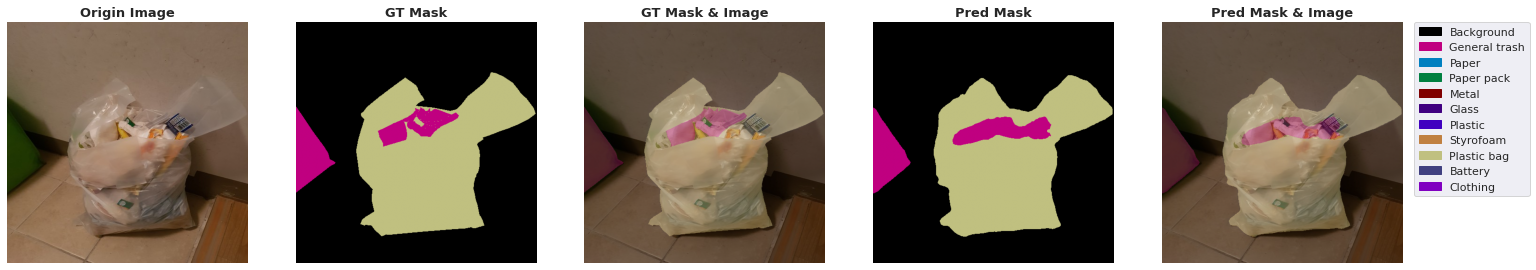

In [49]:
"""
vis_tool(mode, index)
mode: "train", "test", "val"
"""
vis_tool("train", 0)

In [50]:
train_score = []
for i in range(len(train_output)):
    gt = cv2.imread(train_ann_list[i])[:, :, 0]
    pred = train_output[i]
    train_score.append([i, pixel_score(gt, pred)])
train_low_score = sorted(train_score, key = lambda x: x[1])

val_score = []
for i in range(len(val_output)):
    gt = cv2.imread(val_ann_list[i])[:, :, 0]
    pred = val_output[i]
    val_score.append([i, pixel_score(gt, pred)])
val_low_score = sorted(val_score, key = lambda x: x[1])

Image_path: ./data/mmseg/images/training/2068.jpg
GT category: ['Background', 'Paper', 'Plastic']
Pred category: ['Background', 'General trash', 'Paper', 'Plastic']
Pixel Score(Accuracy excluding background): 0.621


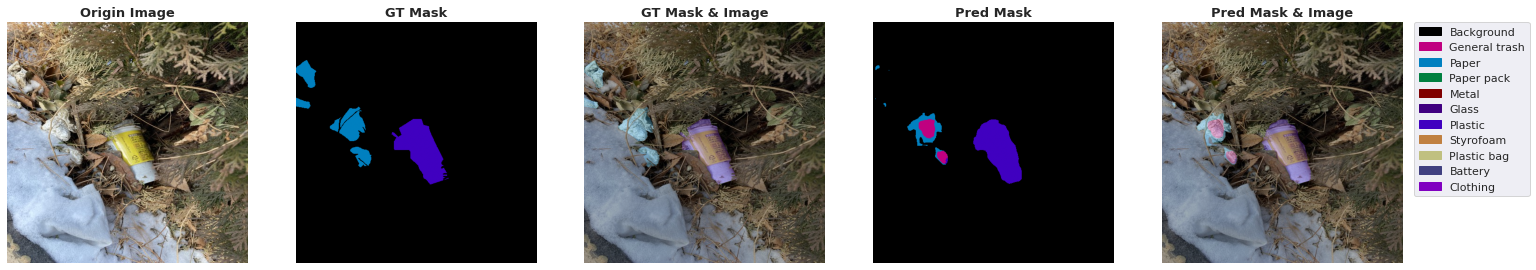

In [61]:
"""
Train set
i: 하위 i번째
=======================
hard data or noise data
"""
i = 5
vis_tool("train", train_low_score[i][0])

Image_path: ./data/mmseg/images/validation/0141.jpg
GT category: ['Background', 'General trash']
Pred category: ['Background', 'Plastic bag']
Pixel Score(Accuracy excluding background): 0.000


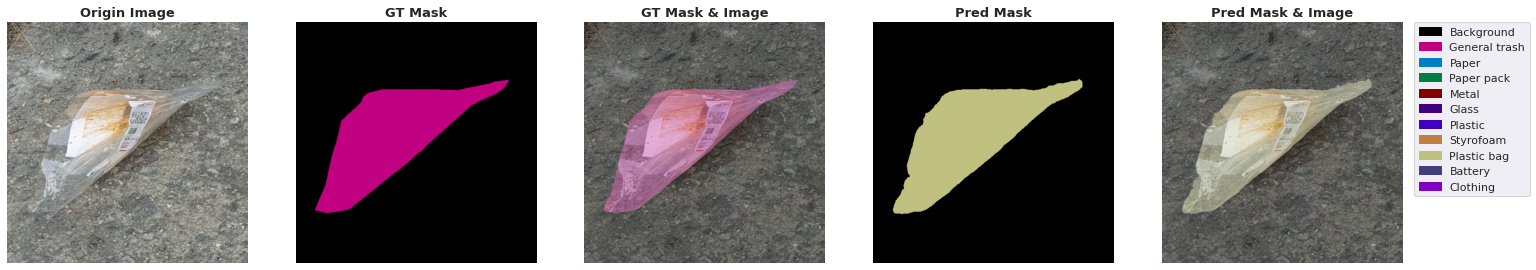

In [59]:
"""
Validation set
i: 하위 i번째
=======================
hard data or noise data
"""
i = 6
vis_tool("val", val_low_score[i][0])

In [100]:
"""
하위 리스트도 가능 -> fold & cleansing 용
"""
hard_list = []
# train
for i in range(50):
    hard_list.append(train_data_list[train_low_score[i][0]])
print(hard_list[0:10])

# val
# for i in range(50):
#     hard_list.append(val_data_list[val_low_score[i][0]])
# print(hard_list[0:10])

['./data/mmseg/images/validation/0035.jpg', './data/mmseg/images/validation/0069.jpg', './data/mmseg/images/validation/0088.jpg', './data/mmseg/images/validation/0110.jpg', './data/mmseg/images/validation/0123.jpg', './data/mmseg/images/validation/0140.jpg', './data/mmseg/images/validation/0141.jpg', './data/mmseg/images/validation/0153.jpg', './data/mmseg/images/validation/0159.jpg', './data/mmseg/images/validation/0161.jpg']
